In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
# from torchvision.transforms import transforms
# from torchvision.datasets import ImageFolder
# import torchvision.models as models
from torch.utils.data import Dataset,DataLoader,SubsetRandomSampler,TensorDataset
# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import os
# from PIL import Image
BASE_DIR = os.getcwd()

In [30]:
device = "cuda"if torch.cuda.is_available() else "cpu"
print("Device using:", device)

Device using: cuda


In [31]:
class MultiHeadAttendtion (nn.Module):
    def __init__(self,embed_dim,num_heads,qkv_bias=True):
        super(MultiHeadAttendtion, self).__init__()
        self.num_head = num_heads
        self.embed_dim = embed_dim
        self.scale = embed_dim**-0.5

        self.query = nn.Conv1d(in_channels=embed_dim,out_channels=embed_dim,kernel_size=1,bias=qkv_bias)
        self.key = nn.Conv1d(in_channels=embed_dim,out_channels=embed_dim,kernel_size=1,bias=qkv_bias)
        self.value = nn.Conv1d(in_channels=embed_dim,out_channels=embed_dim,kernel_size=1,bias=qkv_bias)
        self.proj = nn.Conv1d(in_channels=embed_dim,out_channels=embed_dim,kernel_size=1)
    def forward(self,x):
        B,T,E = x.shape
        q = self.query(x.transpose(1,2)).view(B,self.num_head,E//self.num_head,T).transpose(2,3)
        k = self.key(x.transpose(1,2)).view(B,self.num_head,E//self.num_head,T).transpose(2,3)
        v = self.value(x.transpose(1,2)).view(B,self.num_head,E//self.num_head,T).transpose(2,3)
        atten = (q @ k.transpose(-2,-1)) * self.scale
        atten = atten.softmax(dim=-1)
        x = (atten @ v).transpose(2,3).reshape(B,E,T)
        x = self.proj(x).transpose(1,2)
        return x

class TransformerBlock (nn.Module):
    def __init__(self,embed_dim,num_heads,mlp_ratio=4.0,in_channel=1):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        # self.multi = nn.MultiheadAttention(embed_dim=embed_dim,num_heads=num_heads,add_bias_kv=True) #kdim=embed_dim,vdim=embed_dim
        self.multi = MultiHeadAttendtion(embed_dim=embed_dim,num_heads=num_heads,qkv_bias=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        hidden_dim = (embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim,hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim,embed_dim)
        )
    def forward(self,x):
        # print(x.shape)
        # x = self.norm1(x)
        # x = x + self.multi(x,x,x)[0]
        x = x + self.multi(self.norm1(x))
        # print(x.shape)
        x = x + self.mlp(self.norm2(x))
        return x
    
class EmbeddingLayer (nn.Module):
    def __init__(self,in_channel=1,embed_dim=64,patch_size=128,patch_num=16):
        super(EmbeddingLayer, self).__init__()
        self.patch_num = patch_num
        self.proj = nn.Linear( in_channel * patch_size**2,embed_dim)
        self.dp = nn.Dropout(0.25)
        self.token = nn.Parameter(torch.zeros(1,1,embed_dim))
    def forward(self,x):
        batch_size = x.size(0)
        # print(x.shape)
        x = x.view(batch_size,self.patch_num,-1)
        # print(x.shape)
        embeding = self.proj(x)
        token = self.token.expand(batch_size,-1,-1)
        x = self.dp(torch.cat((token,embeding),dim=1))
        return x
    
class ViT(nn.Module):
    def __init__(self,in_channel=1,class_num=3,embed_dim=64,depth=4,num_head=4,mlp_ratio=4.0):
        super(ViT, self).__init__()
        self.embed_dim = embed_dim
        self.embedding = EmbeddingLayer(in_channel,embed_dim)
        self.transformblock = nn.ModuleList([
            TransformerBlock(embed_dim,num_head,mlp_ratio,in_channel) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim,class_num)
        self.dp = nn.Dropout(0.25)
    def forward(self,x):
        x = self.embedding(x)
        for block in self.transformblock:
            x = self.dp(block(x))
        token = x[:,0]
        token = self.head(self.dp(token))
        return token

        

In [32]:
data_dict = torch.load(os.path.join(BASE_DIR,"Cleaned_ViT_data.pt"),weights_only=False)
tensor__data = data_dict['data']
tensor__data = torch.stack(tensor__data.tolist())
label__data = data_dict['label']
label__data = [0 if a=="cat"else 1 if a=="dog" else 2 for a in label__data]
label__data = torch.tensor(label__data)
train_dataset = TensorDataset(tensor__data, label__data)
tensor__val = data_dict['valdata']
tensor__val = torch.stack(tensor__val.tolist())
label__val = data_dict['vallabel']
label__val = [0 if a=="cat"else 1 if a=="dog" else 2 for a in label__val]
label__val = torch.tensor(label__val)
print(tensor__val.shape)
print(label__val.shape)
val_dataset = TensorDataset(tensor__val, label__val)

torch.Size([303, 16, 128, 128])
torch.Size([303])


In [33]:
bs=64
num_workers=2
train_loader = DataLoader(dataset=train_dataset,shuffle=True,batch_size=bs)
val_loader = DataLoader(dataset=val_dataset,shuffle=True,batch_size=bs)
print(f"Dataset length: {len(train_loader)}")
print(f"Dataset length: {len(val_loader)}")

Dataset length: 5
Dataset length: 5


In [34]:
num_classes = 3   
learning = 0.001
epochs = 100
criteria = nn.CrossEntropyLoss()
model = ViT(1,num_classes,400,4,16,4).to(device=device)
optium = optim.AdamW(model.parameters(),lr=learning,weight_decay=0.1)

In [35]:
model.train()
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
for epoch in range(epochs):
    # print("Entering training loop...")
    correct_pred, total_pred, current_train_loss = 0,0,0
    for image, label in train_loader:
        # print('check')
        image, label = image.to(device),label.to(device)
        # torch.cuda.synchronize()
        optium.zero_grad()
        output = model(image)
        loss = criteria(output,label)
        current_train_loss += loss.item()
        # print(output , label)
        _, predicted = torch.max(output, 1)
        # print(output , predicted)
        correct_pred += (predicted == label).sum().item()
        total_pred += label.size(0)
        loss.backward()
        optium.step()
    train_loss.append(current_train_loss)
    train_accuracy.append(correct_pred/total_pred)
    model.eval()
    with torch.no_grad():
        correct_pred, total_pred,current_val_loss = 0,0,0
        for image,label in val_loader:
            image, label = image.to(device),label.to(device)
            # torch.cuda.synchronize()
            output = model(image)
            loss = criteria(output,label)
            current_val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            # print(output , predicted)
            correct_pred += (predicted == label).sum().item()
            total_pred += label.size(0)
        val_accuracy.append(correct_pred/total_pred)
        val_loss.append(current_val_loss)
    print(f"""epoch: [{epoch+1}/{epochs}], train loss: {current_train_loss:4f}, train acc: {train_accuracy[-1]:4f}, val loss: {current_val_loss:4f}, val acc: {val_accuracy[-1]:4f}""")
# print(correct_pred,total_pred)

epoch: [1/100], train loss: 15.204417, train acc: 0.359736, val loss: 11.260152, val acc: 0.346535
epoch: [2/100], train loss: 9.225347, train acc: 0.399340, val loss: 9.163092, val acc: 0.363036
epoch: [3/100], train loss: 8.365842, train acc: 0.415842, val loss: 7.495718, val acc: 0.349835
epoch: [4/100], train loss: 6.176587, train acc: 0.445545, val loss: 6.670794, val acc: 0.392739
epoch: [5/100], train loss: 5.461522, train acc: 0.435644, val loss: 5.871016, val acc: 0.402640
epoch: [6/100], train loss: 5.251671, train acc: 0.448845, val loss: 5.912235, val acc: 0.429043
epoch: [7/100], train loss: 4.742176, train acc: 0.541254, val loss: 6.619660, val acc: 0.382838
epoch: [8/100], train loss: 4.995703, train acc: 0.495050, val loss: 5.759955, val acc: 0.425743
epoch: [9/100], train loss: 4.715531, train acc: 0.541254, val loss: 6.392554, val acc: 0.415842
epoch: [10/100], train loss: 4.617964, train acc: 0.491749, val loss: 6.110679, val acc: 0.429043
epoch: [11/100], train loss

KeyboardInterrupt: 

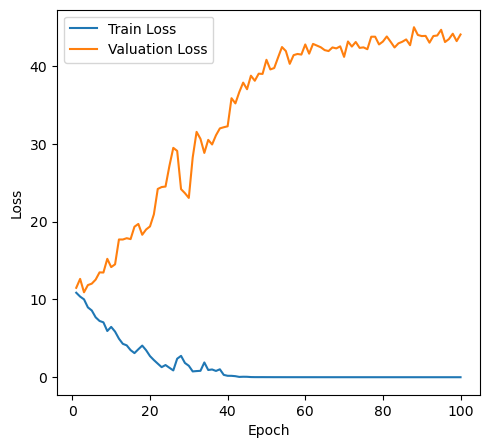

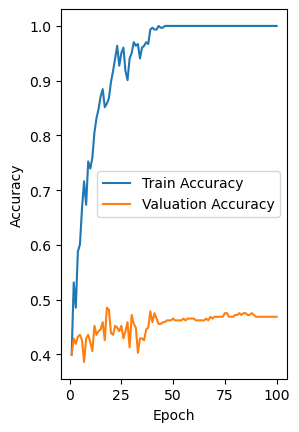

In [ ]:
epochslst = list(range(1, epochs+1))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochslst,train_loss,label="Train Loss")
plt.plot(epochslst,val_loss,label="Valuation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.subplot(1,2,1)
plt.plot(epochslst,train_accuracy,label="Train Accuracy")
plt.plot(epochslst,val_accuracy,label="Valuation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'DCWreg_ViT.pth')